# This notebook consists of 3 key Jupyter Notebooks that produce some of our resulting finding's figures
* They are combined into one large file for convenience of running all of them at once.

# Plot Submission File

In [8]:
import matplotlib.pyplot as plt
import us as usStates
import pandas as pd
from datetime import datetime, timedelta
import json

%matplotlib inline

In [9]:
f = open('../configs/data_cfg/data_cfg.json')
file = json.load(f)
gleam_path = file['gleam_path']

In [10]:
path_submission_file = gleam_path+'2021-01-18-UCSD_NEU-DeepGLEAM.csv'
df_submission1 = pd.read_csv(path_submission_file)

path_submission_file = gleam_path+'2021-01-18-MOBS-GLEAM_COVID.csv'
df_submission2 = pd.read_csv(path_submission_file)
df_submission2 = df_submission2.sort_values(by=['location','target','quantile'])


last_sat = datetime.strptime(df_submission1.target_end_date.min(), '%Y-%m-%d') - timedelta(7)
timeline = [(last_sat+timedelta(7*i)).strftime('%Y-%m-%d') for i in range(-10,5)]

## states

incidence

In [11]:
## surveillance
df = pd.read_csv(gleam_path+'time_series_covid19_deaths_US.csv')
df1 = df.drop(['UID', 'iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key','Population'], axis=1)
df2 = df1.groupby(df1['Province_State']).aggregate('sum')
df2 = df2.drop(['District of Columbia','American Samoa','Guam','Northern Mariana Islands','Virgin Islands','Puerto Rico','Grand Princess','Diamond Princess'],axis = 0)
# groundtruth = df2.diff(axis=1).to_numpy().T[-7:]
df2 = df2.reset_index()
df2 = df2.rename({'Province_State': 'state'}, axis=1)
df2 = df2.melt('state', var_name='date', value_name='deaths')
df2['date'] = pd.to_datetime(df2.date)
df_surveillance = df2.astype({'date': 'str'})

In [12]:
df_submission1

,forecast_date,target,target_end_date,location,type,quantile,value
0,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.010,6342.592749
1,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.025,6426.287789
2,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.050,6469.086389
3,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.100,6518.406680
4,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.150,6551.830348
...,...,...,...,...,...,...,...
9787,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.900,38545.053066
9788,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.950,42558.537229
9789,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.975,46041.312742
9790,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.990,52852.073746


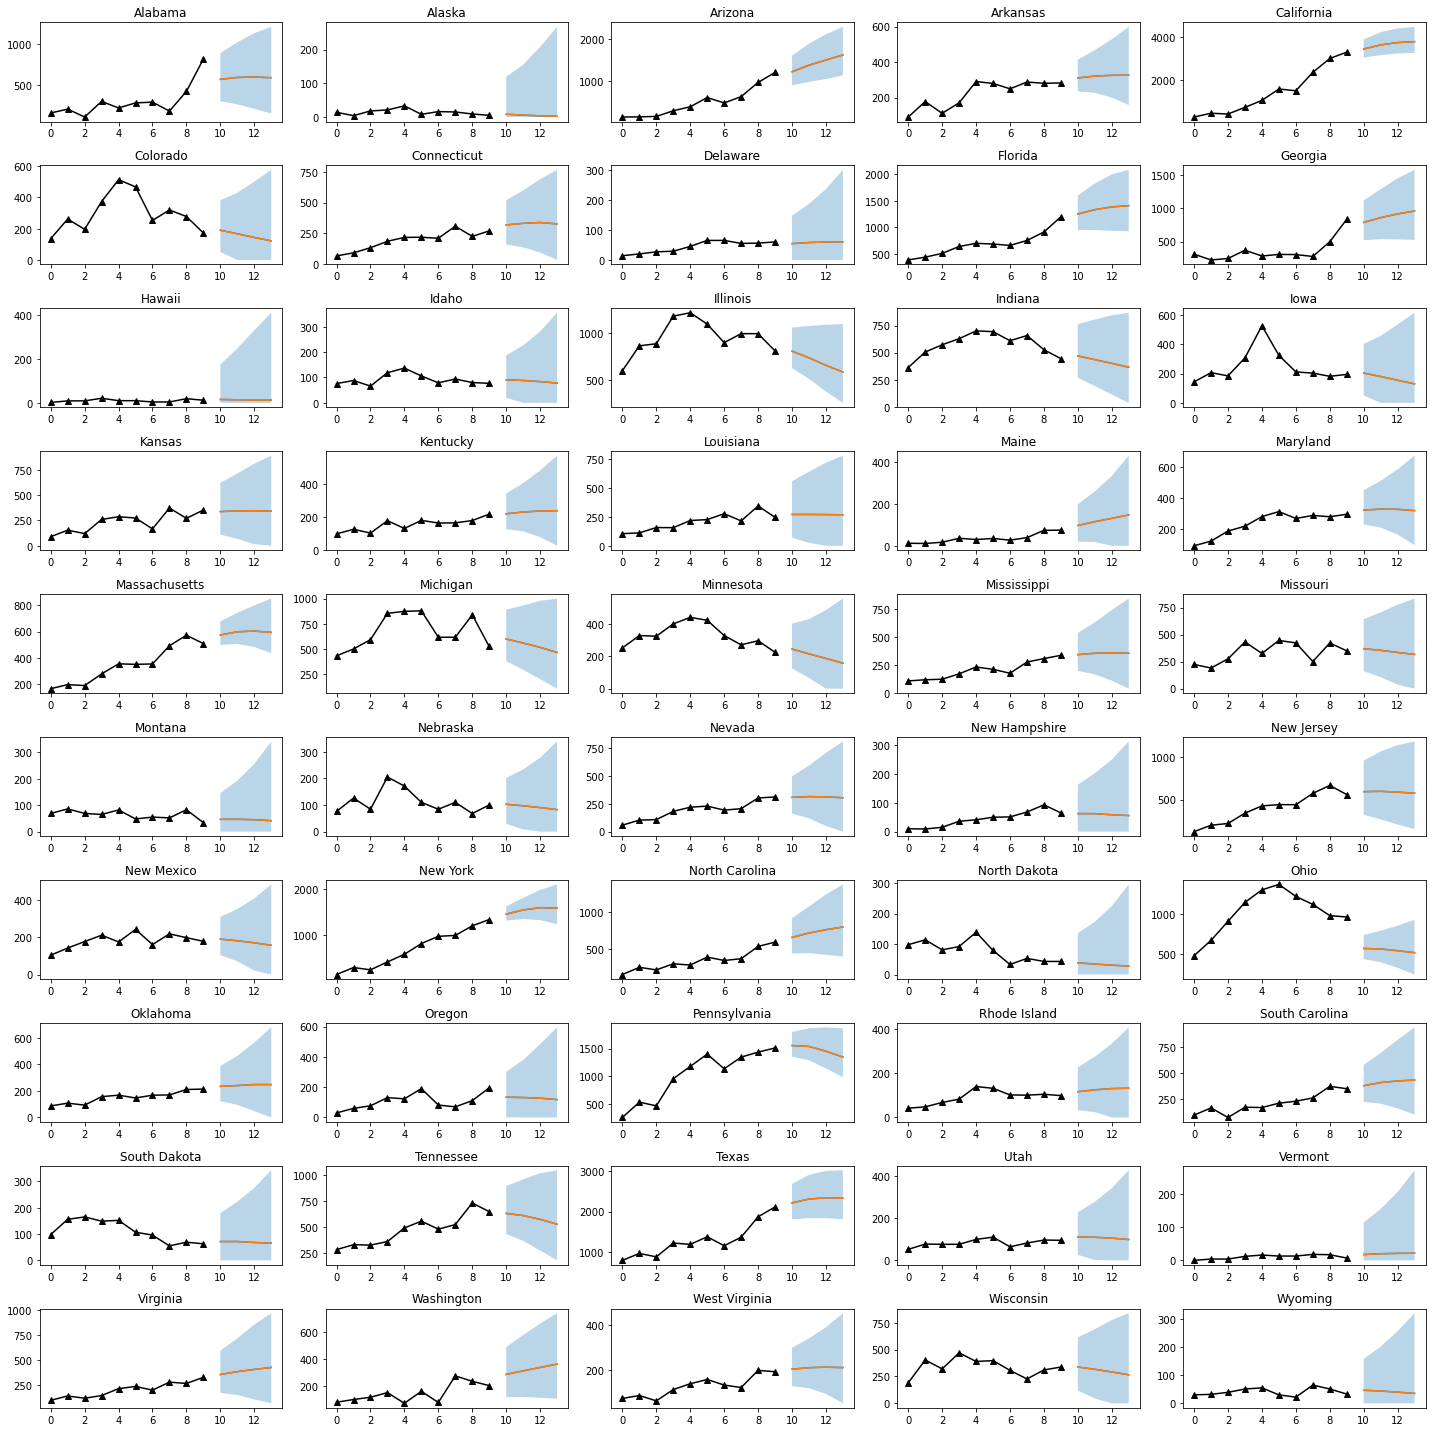

In [16]:
inc_idx = ['inc' in df_submission1.target[i] for i in df_submission1.index]
state_fips_list = [x for x in df_submission1.location.unique() if x!='US']


f, axes = plt.subplots(10, 5, figsize=(20, 20))

for i_state, state_fips in enumerate(state_fips_list):
    i_ax, j_ax = int(i_state/axes.shape[1]), i_state%axes.shape[1]
    ax = axes[i_ax][j_ax]
    state_name = usStates.states.lookup(state_fips).name
    
    ## surveillance
    df_tmp = df_surveillance[df_surveillance.state==state_name]
    df_tmp.index = df_tmp.date
    y_surveillance = df_tmp.deaths[timeline[:-4]].diff()[1:].values
    ax.plot(y_surveillance, 'k^-')
    
    ## prediction
    x_pred = range(len(y_surveillance), len(y_surveillance)+4)
    # median
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['quantile']==0.5)]
    df_tmp.index = df_tmp.target_end_date
    ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], label='median')
    
    # point estimate
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['type']=='point')]
    df_tmp.index = df_tmp.target_end_date
    ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], label='point estimate')
    
    # 95% CI
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['quantile']==0.975)]
    df_tmp.index = df_tmp.target_end_date
    y_upper = df_tmp.value[sorted(df_tmp.index)]
    
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['quantile']==0.025)]
    df_tmp.index = df_tmp.target_end_date
    y_lower = df_tmp.value[sorted(df_tmp.index)]   
    ax.fill_between(x_pred, y_upper, y_lower, alpha=0.3, label='95% CI')
    

    ## settings
    ax.set_title( state_name )
    
f.tight_layout()
f.savefig("../figures/quantile.png")

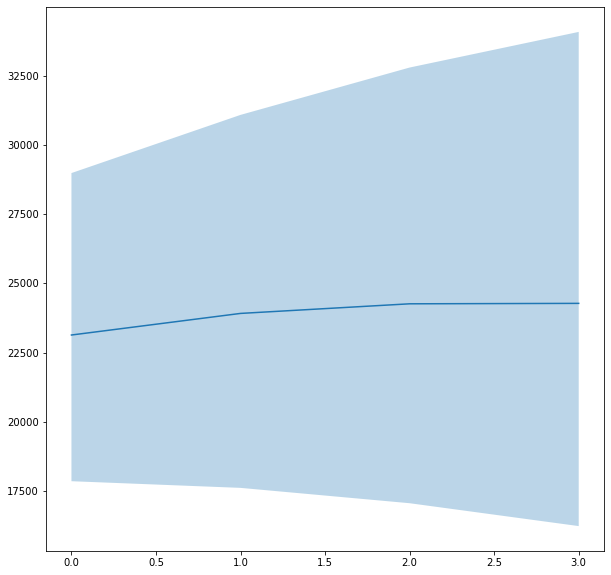

In [17]:
inc_idx = ['inc' in df_submission2.target[i] for i in df_submission2.index]
# state_fips_list = [x for x in df_submission2.location.unique() if x=='US']
# state_fips_list
f, ax = plt.subplots(figsize=(10, 10))

# df_tmp = df_surveillance[df_surveillance.state=='US']
# df_tmp
# df_tmp.index = df_tmp.date
# y_surveillance = df_tmp.deaths[timeline[:-4]].diff()[1:].values
# ax.plot(y_surveillance, 'k^-')

x_pred = range(0, 4)
# median
df_tmp = df_submission2[(df_submission2.location=='US') & inc_idx & (df_submission2['quantile']==0.5)]
df_tmp.index = df_tmp.target_end_date
ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], label='median')

# 95% CI
df_tmp = df_submission2[(df_submission2.location=='US') & inc_idx & (df_submission2['quantile']==0.975)]
df_tmp.index = df_tmp.target_end_date
y_upper = df_tmp.value[sorted(df_tmp.index)]

df_tmp = df_submission2[(df_submission2.location=='US') & inc_idx & (df_submission2['quantile']==0.025)]
df_tmp.index = df_tmp.target_end_date
y_lower = df_tmp.value[sorted(df_tmp.index)]   
ax.fill_between(x_pred, y_upper, y_lower, alpha=0.3, label='95% CI')

# File Generate

# training data clean

In [11]:
import matplotlib.pyplot as plt
import us as usStates
import pandas as pd
import numpy as np
from numpy import savetxt
from datetime import datetime, timedelta
import sys
import os
import matplotlib.pyplot as plt
from sklearn import datasets
import json

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)


# def days(d1, d2):
#     d1 = datetime.strptime(d1, "%m/%d/%Y")
#     d2 = datetime.strptime(d2, "%m/%d/%Y")
#     return abs((d2 - d1).days)+1

Get the Gleam predictions (point esitimate) and calculate the ML Gleam predictions (23 quantiles) 
for the next four week

In [15]:
f = open('../configs/data_cfg/data_cfg.json')
file = json.load(f)
gleam_path = file['gleam_path']
result_path = file['result_path']

In [17]:
df_origin = pd.read_csv(gleam_path+'2021-01-18-MOBS-GLEAM_COVID.csv')
df_origin = df_origin.fillna('NA')
df = df_origin.sort_values(by=['location','target','quantile'])
df1 = df.drop('forecast_date', axis=1)
print(df1.shape)
df2 = df1[(df1.target != '1 wk ahead cum death') & (df1.target != '2 wk ahead cum death')
   & (df1.target != '3 wk ahead cum death')& (df1.target != '4 wk ahead cum death')]
df2 = df1.loc[df1['target'].isin(['1 wk ahead inc death','2 wk ahead inc death',
                                 '3 wk ahead inc death','4 wk ahead inc death'])]
df3 = df2.loc[df2['location'] != 'US']
df4 = df3.loc[df3['type'] == 'point']
print(df2.shape)
print(df3.shape)
print(df4.shape)

(9792, 6)
(4896, 6)
(4800, 6)
(200, 6)


In [18]:
df_1week = df4.loc[df4['target_end_date'] == '2021-01-23']
df_2week = df4.loc[df4['target_end_date'] == '2021-01-30']
df_3week = df4.loc[df4['target_end_date'] == '2021-02-06']
df_4week = df4.loc[df4['target_end_date'] == '2021-02-13']

df_1week = df_1week.drop(['target','target_end_date','type','quantile'], axis=1)
df_2week = df_2week.drop(['target','target_end_date','type','quantile'], axis=1)
df_3week = df_3week.drop(['target','target_end_date','type','quantile'], axis=1)
df_4week = df_4week.drop(['target','target_end_date','type','quantile'], axis=1)


Gleam_week1 = np.expand_dims(df_1week['value'].to_numpy(),axis=1)
Gleam_week2 = np.expand_dims(df_2week['value'].to_numpy(),axis=1)
Gleam_week3 = np.expand_dims(df_3week['value'].to_numpy(),axis=1)
Gleam_week4 = np.expand_dims(df_4week['value'].to_numpy(),axis=1)

print(Gleam_week1.shape)
print(Gleam_week2.shape)
print(Gleam_week3.shape)
print(Gleam_week4.shape)

(50, 1)
(50, 1)
(50, 1)
(50, 1)


In [19]:
ML_residual = np.load(result_path+'ensembledata.npy')
# ML_residual = np.load('ensembledata_torchts.npy')
    
ML_residual1 = ML_residual[0]
ML_residual2 = ML_residual[1]
ML_residual3 = ML_residual[2]
ML_residual4 = ML_residual[3]

print(ML_residual1.shape)
print(ML_residual2.shape)
print(ML_residual3.shape)
print(ML_residual4.shape)

(50, 23)
(50, 23)
(50, 23)
(50, 23)


In [20]:
ML_Gleam_death1 = np.flip(Gleam_week1 - ML_residual1,axis =1)
ML_Gleam_death2 = np.flip(Gleam_week2 - ML_residual2,axis =1)
ML_Gleam_death3 = np.flip(Gleam_week3 - ML_residual3,axis =1)
ML_Gleam_death4 = np.flip(Gleam_week4 - ML_residual4,axis =1)

print(22*50-sum(sum(np.diff(ML_Gleam_death1)>=0)))
print(22*50-sum(sum(np.diff(ML_Gleam_death2)>=0)))
print(22*50-sum(sum(np.diff(ML_Gleam_death3)>=0)))
print(22*50-sum(sum(np.diff(ML_Gleam_death4)>=0)))

print(np.sum(np.array(ML_Gleam_death1) < 0, axis=0))
print(np.sum(np.array(ML_Gleam_death2) < 0, axis=0))
print(np.sum(np.array(ML_Gleam_death3) < 0, axis=0))
print(np.sum(np.array(ML_Gleam_death4) < 0, axis=0))

#set to positive
ML_Gleam_death1 = np.maximum(ML_Gleam_death1,0)
ML_Gleam_death2 = np.maximum(ML_Gleam_death2,0)
ML_Gleam_death3 = np.maximum(ML_Gleam_death3,0)
ML_Gleam_death4 = np.maximum(ML_Gleam_death4,0)

print(np.sum(np.array(ML_Gleam_death1) < 0, axis=0))
print(np.sum(np.array(ML_Gleam_death2) < 0, axis=0))
print(np.sum(np.array(ML_Gleam_death3) < 0, axis=0))
print(np.sum(np.array(ML_Gleam_death4) < 0, axis=0))


0
0
0
0
[13  9  7  6  4  3  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[20 13 10  6  6  4  3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0]
[25 19 15 12  7  6  5  4  3  2  2  0  0  0  0  0  0  0  0  0  0  0  0]
[33 25 21 16 15 12  6  6  4  2  2  0  0  0  0  0  0  0  0  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [21]:
#inc data use sorted ML Leam death
# add US. data
US_death1 = np.append(ML_Gleam_death1,np.expand_dims(np.sum(ML_Gleam_death1,axis = 0),axis=0),axis = 0)
US_death2 = np.append(ML_Gleam_death2,np.expand_dims(np.sum(ML_Gleam_death2,axis = 0),axis=0),axis = 0)
US_death3 = np.append(ML_Gleam_death3,np.expand_dims(np.sum(ML_Gleam_death3,axis = 0),axis=0),axis = 0)
US_death4 = np.append(ML_Gleam_death4,np.expand_dims(np.sum(ML_Gleam_death4,axis = 0),axis=0),axis = 0)

# copy 50% quantile for point
inc_death1 = np.insert(US_death1,23,US_death1[:,11],axis = 1)
inc_death2 = np.insert(US_death2,23,US_death2[:,11],axis = 1)
inc_death3 = np.insert(US_death3,23,US_death3[:,11],axis = 1)
inc_death4 = np.insert(US_death4,23,US_death4[:,11],axis = 1)

generate the submission file

In [22]:
# previous death
cumweek1 = df1.loc[(df1['target'] =='1 wk ahead cum death') & (df1['type'] == 'point')]
incweek1 = df1.loc[(df1['target'] =='1 wk ahead inc death')& (df1['type'] == 'point')]
cumweek_1 = cumweek1['value'].to_numpy()
incweek_1 = incweek1['value'].to_numpy()
previous_death = np.around(cumweek_1 - incweek_1).astype(int)
print(previous_death)

[  6119    229  11248   4293  33342   5363   6594   1016  24004  12291
    319   1605  20020   9287   4321   3489   3093   8080    507   6541
  13583  14669   5955   5481   6467   1088   1837   3761    927  20414
   2910  40806   8016   1403  10135   2952   1799  19143   2005   6108
   1633   8355  32428   1485    163   5706   3903   1761   5905    522
 395785]


In [23]:
# cum death
cum_death1 = np.add(inc_death1,np.expand_dims(previous_death,axis = 1))
cum_death2 = np.add(inc_death2,cum_death1)
cum_death3 = np.add(inc_death3,cum_death2)
cum_death4 = np.add(inc_death4,cum_death3)


In [24]:
# all the data
value_data = np.stack([cum_death1,inc_death1,cum_death2,inc_death2,
                             cum_death3,inc_death3,cum_death4,inc_death4],axis=1).flatten()
# add to the value column
print(value_data.shape)

(9792,)


In [25]:
df.drop(columns=['value'])
df['value'] = value_data

df = df.astype({'forecast_date': 'string','target': 'string', 'target_end_date': 'string', 'location': 'string',
          'type': 'string', 'location': 'string', 'value': 'float64'})



In [36]:
df.dtypes

forecast_date       string
target              string
target_end_date     string
location            string
type                string
quantile            object
value              float64
dtype: object

In [26]:
df.to_csv(gleam_path+'2021-01-18-UCSD_NEU-DeepGLEAM.csv',index=False)

# Ensemble-Analysis Residual

In [21]:
import pandas as pd
import numpy as np
import json

from numpy import savetxt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import sys
np.set_printoptions(threshold=sys.maxsize)
import os
import matplotlib.pyplot as plt
from sklearn import datasets
import glob

from datetime import datetime

def days(d1, d2):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    d2 = datetime.strptime(d2, "%m/%d/%Y")
    return abs((d2 - d1).days)+1

In [22]:
f = open('../configs/data_cfg/data_cfg.json')
result_path = json.load(f)['result_path']

In [24]:
numpy_vars = {}
i = 0
for np_name in glob.glob(result_path+'plotweek55result/*.npz'):
    numpy_vars[i] = np.load(np_name)['prediction']
    i = i +1
ML_ensemble = np.stack([numpy_vars[i] for i in range(10)], axis = 0)
ML_ensemble = np.squeeze(ML_ensemble,axis=2)
#ML_ensemble = ML_ensemble.reshape(10,4,50,3)
print(ML_ensemble.shape)
ML_ensemble = np.mean(ML_ensemble,axis=0)
print(ML_ensemble.shape)

(10, 4, 50, 3)
(4, 50, 3)


generate analysis result (MAE, RMSE, MIS, total death)

In [25]:
ML_ensemble[0,1]

array([-107.724815 ,    3.0535336,   71.83182  ], dtype=float32)

In [26]:
ML_ensemble.shape

(4, 50, 3)

In [27]:
ML_ensemble_list = []
for i in range (4):
    range_low = ML_ensemble[i,:,1:2] - np.dot(ML_ensemble[i,:,1:2] - ML_ensemble[i,:,0:1],
                                 np.array([[2.576,1.96,1.645,1.282,1.036,0.842,0.674,0.524,0.385,0.253,0.126]]))/1.96

    range_high = ML_ensemble[i,:,1:2] + np.dot(ML_ensemble[i,:,2:3] - ML_ensemble[i,:,1:2],
                                 np.array([[0.126,0.253,0.385,0.524,0.674,0.842,1.036,1.282,1.645,1.96,2.576]]))/1.96
    
    tmp_ML_allquantile = np.concatenate([range_low,ML_ensemble[i,:,1:2],range_high],axis=1)
    ML_ensemble_list.append(tmp_ML_allquantile)
    
ML_ensemble_new = np.stack(ML_ensemble_list,axis=0)
print(ML_ensemble_new.shape)
    

(4, 50, 23)


In [28]:
ML_ensemble_new[0,1]

array([-142.54087039, -107.72481728,  -89.92115375,  -69.40455102,
        -55.5007376 ,  -44.53594165,  -35.04065444,  -26.56271942,
        -18.70649964,  -11.24591683,   -4.06793186,    3.05353355,
          7.47499455,   11.93154651,   16.56355327,   21.44119675,
         26.70484079,   32.60012212,   39.40776841,   48.04014464,
         60.77816323,   71.83181572,   93.44784726])

number of crossing

In [29]:
np.sum(np.diff(ML_ensemble_new,axis=2) <= 0)

0

solve crossing problem by setting number larger

In [30]:
# ML_diff = np.diff(ML_ensemble_new,axis=2)
# ML_diff = np.maximum(ML_diff,0)
# ML_diff = np.concatenate([ML_ensemble_new[...,:1],ML_diff],axis=2)
# ML_new_ensemble = np.cumsum(ML_diff,axis=2)

# print(ML_diff.shape)
# print(ML_new_ensemble.shape)

# np.sum(np.diff(ML_new_ensemble,axis=2) ==0)

# np.save('ensembledata.npy', ML_new_ensemble)

In [31]:
np.sum(np.diff(ML_ensemble_new,axis=2) ==0)

0

In [32]:
np.save(result_path+'ensembledata.npy', ML_ensemble_new)